In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 8*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

2023-02-12 22:16:02.938373: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-12 22:16:03.175557: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-12 22:16:03.862822: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

1 Physical GPUs, 1 Logical GPUs


In [2]:
from local_utils import *

In [3]:
sim_name = "Koch_Meinhardt_5"
x_slice=slice(60,100,1)#slice(30,65,1)#slice(0,100,1)#slice(30,65,1)#slice(50,65,1)#
y_slice=slice(0,40,1)#slice(50,85,1)#slice(0,100,1)#slice(50,85,1)#slice(70,85,1)#
pattern = load(sim_name, x_slice, y_slice,
               data_time_start=-3,
               data_time_len=2,
               data_time_step=1)

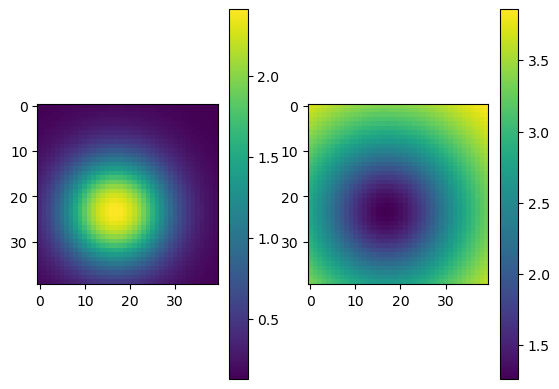

In [4]:
plt.subplot(121)
plt.imshow(pattern.c[0,:,:,-1])
plt.colorbar()
plt.subplot(122)
plt.imshow(pattern.c[1,:,:,-1])
plt.colorbar()
#lt.tight_layout()
plt.show()

In [5]:

def grads(pinn, ts):
    
    with tf.GradientTape(persistent=True) as tape:
        H = pinn.make_inputs(ts)
        tape.watch(H)      
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(H)            
            outputs1, outputs2 = pinn.net(H)            
        
            u = tf.squeeze(outputs1[:, :, :, 0])
            v = tf.squeeze(outputs1[:, :, :, 1])
            
            u2 = tf.squeeze(outputs2[:, :, :, 0])
            v2 = tf.squeeze(outputs2[:, :, :, 1])
            
        grad_u = tape2.gradient(u2, H)        
        u_x = grad_u[:, :, :, 0]
        u_y = grad_u[:, :, :, 1]
        u_t = grad_u[:, :, :, 2]

        grad_v = tape2.gradient(v2, H)
        v_x = grad_v[:, :, :, 0]
        v_y = grad_v[:, :, :, 1]
        v_t = grad_v[:, :, :, 2]
            
    grad_u_x = tape.gradient(u_x, H)
    u_xx = grad_u_x[:, :, :, 0]
    u_yx = grad_u_x[:, :, :, 1]
    #u_tx = grad_u_x[:, :, :, 2]
    grad_u_y = tape.gradient(u_y, H)
    u_xy = grad_u_y[:, :, :, 0]
    u_yy = grad_u_y[:, :, :, 1]
    #u_ty = grad_u_y[:, :, :, 2]
    grad_v_x = tape.gradient(v_x, H)
    v_xx = grad_v_x[:, :, :, 0]
    v_yx = grad_v_x[:, :, :, 1]
    #v_tx = grad_v_x[:, :, :, 2]
    grad_v_y = tape.gradient(v_y, H)
    v_xy = grad_v_y[:, :, :, 0]
    v_yy = grad_v_y[:, :, :, 1]
    #v_ty = grad_v_y[:, :, :, 2]
    return (tf.squeeze(u),
            tf.squeeze(u_xx), tf.squeeze(u_yy), tf.squeeze(u_xy), tf.squeeze(u_yx), tf.squeeze(u_t),
            tf.squeeze(v),
            tf.squeeze(v_xx), tf.squeeze(v_yy), tf.squeeze(v_xy), tf.squeeze(v_yx), tf.squeeze(v_t))

def grads2(pinn, ts):
    
    with tf.GradientTape(persistent=True) as tape:
        H = pinn.make_inputs(ts)
        tape.watch(H)      
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(H)            
            _, outputs2 = pinn.net(H)            
        
            
            u = tf.squeeze(outputs2[:, :, :, 0])
            v = tf.squeeze(outputs2[:, :, :, 1])
            
        grad_u = tape2.gradient(u, H)        
        u_x = grad_u[:, :, :, 0]
        u_y = grad_u[:, :, :, 1]
        u_t = grad_u[:, :, :, 2]

        grad_v = tape2.gradient(v, H)
        v_x = grad_v[:, :, :, 0]
        v_y = grad_v[:, :, :, 1]
        v_t = grad_v[:, :, :, 2]
            
    grad_u_x = tape.gradient(u_x, H)
    u_xx = grad_u_x[:, :, :, 0]
    u_yx = grad_u_x[:, :, :, 1]
    #u_tx = grad_u_x[:, :, :, 2]
    grad_u_y = tape.gradient(u_y, H)
    u_xy = grad_u_y[:, :, :, 0]
    u_yy = grad_u_y[:, :, :, 1]
    #u_ty = grad_u_y[:, :, :, 2]
    grad_v_x = tape.gradient(v_x, H)
    v_xx = grad_v_x[:, :, :, 0]
    v_yx = grad_v_x[:, :, :, 1]
    #v_tx = grad_v_x[:, :, :, 2]
    grad_v_y = tape.gradient(v_y, H)
    v_xy = grad_v_y[:, :, :, 0]
    v_yy = grad_v_y[:, :, :, 1]
    #v_ty = grad_v_y[:, :, :, 2]
    return (tf.squeeze(u),
            tf.squeeze(u_xx), tf.squeeze(u_yy), tf.squeeze(u_xy), tf.squeeze(u_yx), tf.squeeze(u_t),
            tf.squeeze(v),
            tf.squeeze(v_xx), tf.squeeze(v_yy), tf.squeeze(v_xy), tf.squeeze(v_yx), tf.squeeze(v_t))


In [6]:
def gen_series():    
    for i,t in enumerate(pattern.t_star):
        yield t, pattern.c[..., i]
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=((), pattern.c.shape[:-1]))

In [7]:
pattern.t_star.shape

(2,)

In [59]:
class NN_Field3(tu.NN_Field):
    
    def build(self):
        """Create the state of the layers (weights)"""
        self.weights = []
        self.scales = []
        self.biases = []

        for i, (input_n, output_n) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            rnd_init = tf.random_normal_initializer(stddev=1 /(input_n + output_n))
            W = tf.Variable(self.__make_variables__([1, self.dim_2d[0], self.dim_2d[1], input_n, output_n], rnd_init), dtype=self.dtype, name=f"W{i+1}")
            a = tf.Variable(tf.ones([1, self.dim_2d[0], self.dim_2d[1], output_n], dtype=self.dtype), dtype=self.dtype, name=f"a{i+1}")
            b = tf.Variable(tf.zeros([1, self.dim_2d[0], self.dim_2d[1], output_n], dtype=self.dtype), dtype=self.dtype, name=f"b{i+1}")
            self.weights.append(W)
            self.scales.append(a)
            self.biases.append(b)
            
    def net(self, H):
        for W, a, b in zip(self.weights, self.scales, self.biases):            
            #print("H",H)
            #print("W",W)
            #mul_outputs = tf.tensordot(H, W, axes=[[-1], [-1]])                        
            mul_outputs = [tf.reduce_sum(H*W[:, :, :, :, i], axis=-1) for i in range(W.shape[-1])]            
            mul_outputs =tf.concat([mo[:, :, :, tf.newaxis] for mo in mul_outputs], axis=-1)
            #print("mul_outputs",mul_outputs)
            #mul_outputs = tf.reduce_prod(mul_outputs, axis=4)
            #print(mul_outputs.shape)
            outputs = a * mul_outputs + b
            #print("outputs",outputs)
            #print("====================================")
            # H = tf.tanh(outputs)
            # H = tf.sigmoid(outputs)
            H = self.act(outputs)

        return outputs
    
class NN_Field4(tu.NN_Field):
    def build(self):
        """Create the state of the layers (weights)"""
        self.weights = []
        self.scales = []
        self.biases = []

        for i, (input_n, output_n) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            rnd_init = tf.random_normal_initializer(stddev=1 /(input_n + output_n))
            W = tf.Variable(self.__make_variables__([1, self.dim_2d[0], self.dim_2d[1], input_n, output_n], rnd_init), dtype=self.dtype, name=f"W{i+1}")
            a = tf.Variable(tf.ones([1, self.dim_2d[0], self.dim_2d[1], output_n], dtype=self.dtype), dtype=self.dtype, name=f"a{i+1}")
            b = tf.Variable(tf.zeros([1, self.dim_2d[0], self.dim_2d[1], output_n], dtype=self.dtype), dtype=self.dtype, name=f"b{i+1}")
            self.weights.append(W)
            self.scales.append(a)
            self.biases.append(b)
            if i == 1:
                self.c1x = tf.Variable(.01*tf.ones([1, 25, output_n, output_n], dtype=self.dtype), dtype=self.dtype, name=f"c{i+1}x")
                self.c1y = tf.Variable(.01*tf.ones([25, 1, output_n, output_n], dtype=self.dtype), dtype=self.dtype, name=f"c{i+1}y")
            if i == 2:
                self.c2x = tf.Variable(.01*tf.ones([1, 25, output_n, output_n], dtype=self.dtype), dtype=self.dtype, name=f"c{i+1}x")
                self.c2y = tf.Variable(.01*tf.ones([25, 1, output_n, output_n], dtype=self.dtype), dtype=self.dtype, name=f"c{i+1}y")                
                
    def act(self,x):
        return tf.tanh(x)
    
    @tf.function        
    def net(self, H):
        for i, (W, a, b) in enumerate(zip(self.weights, self.scales, self.biases)):
            #print("H",H)
            #print("W",W)
            #mul_outputs = tf.tensordot(H, W, axes=[[-1], [-1]])                        
            if i == 1:
                H = tf.nn.conv2d(H, self.c1x, strides=[1], padding="SAME")
                H = tf.nn.conv2d(H, self.c1y, strides=[1], padding="SAME")
            if i == 2:
                H = tf.nn.conv2d(H, self.c2x, strides=[1], padding="SAME")
                H = tf.nn.conv2d(H, self.c2y, strides=[1], padding="SAME")
            mul_outputs = [tf.reduce_sum(H*W[:, :, :, :, i], axis=-1) for i in range(W.shape[-1])]            
            mul_outputs =tf.concat([mo[:, :, :, tf.newaxis] for mo in mul_outputs], axis=-1)
            #print("mul_outputs",mul_outputs)
            #mul_outputs = tf.reduce_prod(mul_outputs, axis=4)
            #print(mul_outputs.shape)
            outputs = a * mul_outputs + b
            #print("outputs",outputs)
            #print("====================================")
            # H = tf.tanh(outputs)
            # H = tf.sigmoid(outputs)
            H = self.act(outputs)

        return outputs
    
class NN_Field5(tu.NN_Field):
    def build(self):
        """Create the state of the layers (weights)"""
        self.weights = []
        self.scales = []
        self.biases = []

        for i, (input_n, output_n) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            rnd_init = tf.random_normal_initializer(stddev=1 / (input_n + output_n))
            W = tf.Variable(self.__make_variables__([output_n, input_n], rnd_init), dtype=self.dtype, name=f"W{i+1}")
            a = tf.Variable(tf.ones([1, 1, 1, output_n], dtype=self.dtype), dtype=self.dtype, name=f"a{i+1}")
            b = tf.Variable(tf.zeros([1, 1, 1, output_n], dtype=self.dtype), dtype=self.dtype, name=f"b{i+1}")
            self.weights.append(W)
            self.scales.append(a)
            self.biases.append(b)
            if i == 1:
                #self.c1x = tf.Variable(.01*tf.ones([1, 3, output_n, output_n], dtype=self.dtype), dtype=self.dtype, name=f"c{i+1}x")
                #self.c1y = tf.Variable(.01*tf.ones([3, 1, output_n, output_n], dtype=self.dtype), dtype=self.dtype, name=f"c{i+1}y")
                self.c1 = tf.Variable(.0001*tf.ones([25, 25, output_n, output_n], dtype=self.dtype), dtype=self.dtype, name=f"c{i+1}y")
            if i == 2:
                #self.c2x = tf.Variable(.01*tf.ones([1, 3, output_n, output_n], dtype=self.dtype), dtype=self.dtype, name=f"c{i+1}x")
                #self.c2y = tf.Variable(.01*tf.ones([3, 1, output_n, output_n], dtype=self.dtype), dtype=self.dtype, name=f"c{i+1}y")                
                self.c2 = tf.Variable(.0001*tf.ones([25, 25, output_n, output_n], dtype=self.dtype), dtype=self.dtype, name=f"c{i+1}y")
                
    #def act(self,x):
    #    return tf.tanh(x)
    
    @tf.function        
    def net(self, H):
        for i, (W, a, b) in enumerate(zip(self.weights, self.scales, self.biases)):
            #print("H",H)
            #print("W",W)
            #mul_outputs = tf.tensordot(H, W, axes=[[-1], [-1]])                        
            if i == 1:
                #H = tf.nn.conv2d(H, self.c1x, strides=[1], padding="SAME")
                #H = tf.nn.conv2d(H, self.c1y, strides=[1], padding="SAME")
                H = tf.nn.conv2d(H, self.c1, strides=[1], padding="SAME")
            if i == 2:
                #H = tf.nn.conv2d(H, self.c2x, strides=[1], padding="SAME")
                #H = tf.nn.conv2d(H, self.c2y, strides=[1], padding="SAME")
                H = tf.nn.conv2d(H, self.c2, strides=[1], padding="SAME")
            mul_outputs = tf.tensordot(H, W, axes=[[-1], [-1]])
            outputs = a * mul_outputs + b
            H = self.act(outputs)

        return outputs
    
class NN_Field6(tu.NN_Field):
    def __init__(self, x_range, y_range, layers, layers2, dim_2d, dtype=tf.float32, **kwargs):
        self.layers2 = layers2
        super().__init__(x_range, y_range, layers, dim_2d, dtype, **kwargs)
        
    def build(self):
        """Create the state of the layers (weights)"""
        self.weights = []
        self.scales = []
        self.biases = []

        for i, (input_n, output_n) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            rnd_init = tf.random_normal_initializer(stddev=1 / (input_n + output_n))
            W = tf.Variable(
                self.__make_variables__([1, self.dim_2d[0], self.dim_2d[1], input_n, output_n], rnd_init),
                dtype=self.dtype,
                name=f"W1_{i+1}",
            )
            a = tf.Variable(
                tf.ones([1, self.dim_2d[0], self.dim_2d[1], output_n], dtype=self.dtype),
                dtype=self.dtype,
                name=f"a1_{i+1}",
            )
            b = tf.Variable(
                tf.zeros([1, self.dim_2d[0], self.dim_2d[1], output_n], dtype=self.dtype),
                dtype=self.dtype,
                name=f"b1_{i+1}",
            )
            self.weights.append(W)
            self.scales.append(a)
            self.biases.append(b)
            if i == 1:
                self.c1 = tf.Variable(.01*tf.ones([25, 25, output_n, output_n], dtype=self.dtype), dtype=self.dtype, name=f"c{i+1}")
            if i == 2:
                self.c2 = tf.Variable(.01*tf.ones([25, 25, output_n, output_n], dtype=self.dtype), dtype=self.dtype, name=f"c{i+1}")                
            self.weights2 = []
            self.scales2 = []
            self.biases2 = []

            for i, (input_n, output_n) in enumerate(zip(self.layers2[:-1], self.layers2[1:])):
                rnd_init = tf.random_normal_initializer(stddev=1 / (input_n + output_n))
                W = tf.Variable(self.__make_variables__([output_n, input_n], rnd_init), dtype=self.dtype, name=f"W2_{i+1}")
                a = tf.Variable(tf.ones([1, 1, 1, output_n], dtype=self.dtype), dtype=self.dtype, name=f"a2_{i+1}")
                b = tf.Variable(tf.zeros([1, 1, 1, output_n], dtype=self.dtype), dtype=self.dtype, name=f"b2_{i+1}")
                if i == 1:
                    self.c2_1 = tf.Variable(.1*tf.ones([25, 25, output_n, output_n], dtype=self.dtype), dtype=self.dtype, name=f"c2_{i+1}")
                if i == 2:
                    self.c2_2 = tf.Variable(.1*tf.ones([25, 25, output_n, output_n], dtype=self.dtype), dtype=self.dtype, name=f"c2_{i+1}")                
                self.weights2.append(W)
                self.scales2.append(a)
                self.biases2.append(b) 
                
    def act(self,x):
        return tf.tanh(x)
    def act2(self,x):
        return x*tf.sigmoid(x)
    
    @tf.function        
    def net(self, H):
        for i, (W, a, b) in enumerate(zip(self.weights, self.scales, self.biases)):
            if i == 1:
                H = tf.nn.conv2d(H, self.c1, strides=[1], padding="SAME")
            if i == 2:
                H = tf.nn.conv2d(H, self.c2, strides=[1], padding="SAME")
            mul_outputs = [tf.reduce_sum(H * W[:, :, :, :, i], axis=-1) for i in range(W.shape[-1])]
            mul_outputs = tf.concat([mo[:, :, :, tf.newaxis] for mo in mul_outputs], axis=-1)
            outputs = a * mul_outputs + b
            H = self.act(outputs)
        outputs1 = outputs
        for i, (W, a, b) in enumerate(zip(self.weights2, self.scales2, self.biases2)):
            if i == 1:
                H = tf.nn.conv2d(H, self.c2_1, strides=[1], padding="SAME")
            if i == 2:
                H = tf.nn.conv2d(H, self.c2_2, strides=[1], padding="SAME")
            mul_outputs = tf.tensordot(H, W, axes=[[-1], [-1]])
            outputs = a * mul_outputs + b
            H = self.act(outputs)
        outputs += outputs1

        return outputs1, outputs

In [60]:

x_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[0]
y_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[1]
x_range = x_range[x_slice]
y_range = y_range[y_slice]

optimizer=keras.optimizers.Adam(learning_rate=1e-2)#keras.optimizers.SGD(learning_rate=1e-4)#
optimizer2=keras.optimizers.Adam(learning_rate=1e-4)#keras.optimizers.SGD(learning_rate=1e-4)#


pinn = NN_Field6(x_range, y_range, 
                   layers=[3, 8, 8, 8, 2], 
                   layers2=[2, 128, 128, 128, 2], 
                   dim_2d=(pattern.block_x, pattern.block_x), 
                   dtype=tf.float32)
norm_l2 = L2()

init_per = 1.0
D_u = tf.constant(pattern.params["D_u"], pinn.dtype, name="D_u")#tf.Variable(pattern.params["D_u"]*init_per, pinn.dtype)
D_v = tf.constant(pattern.params["D_v"], pinn.dtype, name="D_v")#tf.Variable(pattern.params["D_v"]*init_per, pinn.dtype)
def clip_by_value_zero_lb(z):
    return tf.clip_by_value(z, 1e-4, 1e10,)

sigma_u = tf.Variable(pattern.params["sigma_u"]*init_per,
                      pinn.dtype,
                      name="sigma_u",
                      constraint=clip_by_value_zero_lb)


sigma_v = tf.Variable(pattern.params["sigma_v"]*init_per,
                      pinn.dtype,
                      name="sigma_v",
                      constraint=clip_by_value_zero_lb)

mu_u = tf.Variable(pattern.params["mu_u"]*init_per,
                   pinn.dtype,
                   name="mu_u",
                   constraint=clip_by_value_zero_lb)

rho_u = tf.Variable(pattern.params["rho_u"]*init_per,
                    pinn.dtype,
                    name="rho_u",
                    constraint=clip_by_value_zero_lb)

rho_v = tf.Variable(pattern.params["rho_v"]*init_per,
                    pinn.dtype,
                    name="rho_v",
                    constraint=clip_by_value_zero_lb)

kappa_u = tf.Variable(pattern.params["kappa_u"]*init_per,
                      pinn.dtype,
                      name="kappa_u",
                      constraint=clip_by_value_zero_lb)


params_tf = (sigma_u, sigma_v, mu_u, rho_u, rho_v, kappa_u,)
@tf.function
def train_step(elements):
    with tf.GradientTape(persistent=True) as tape: 
        H = pinn.make_inputs(elements[0])
        tape.watch(H)
        trainables = pinn.trainable_variables
        outputs1, _ = pinn.net(H)            
        u = tf.squeeze(outputs1[:, :, :, 0])
        v = tf.squeeze(outputs1[:, :, :, 1])

        u_diff = u - elements[1][:, 0, :, :]
        v_diff = v - elements[1][:, 1, :, :]
        l2_u_obs = tf.reduce_sum(u_diff**2)
        l2_v_obs = tf.reduce_sum(v_diff**2)                
        l2 = l2_u_obs + l2_v_obs 
       
    grads = tape.gradient(l2, trainables)
    optimizer.apply_gradients(zip(grads, trainables))
    return (l2_u_obs, l2_v_obs)

@tf.function
def train_step_inverse(elements):
    with tf.GradientTape(persistent=True) as tape: 
        H = pinn.make_inputs(elements[0])
        tape.watch(H)
        trainables = pinn.trainable_variables

        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(H)
            
            outputs1, outputs2 = pinn.net(H)            
            u = tf.squeeze(outputs1[:, :, :, 0])
            v = tf.squeeze(outputs1[:, :, :, 1])
            
            u2 = tf.squeeze(outputs2[:, :, :, 0])
            v2 = tf.squeeze(outputs2[:, :, :, 1])
            
            grad_u = tape2.gradient(u2, H)
            u_x = grad_u[:, :, :, 0]
            u_y = grad_u[:, :, :, 1]
            u_t = grad_u[:, :, :, 2]
            
            grad_v = tape2.gradient(v2, H)
            v_x = grad_v[:, :, :, 0]
            v_y = grad_v[:, :, :, 1]
            v_t = grad_v[:, :, :, 2]
                    
        grad_u_x = tape.gradient(u_x, H)
        u_xx = grad_u_x[:, :, :, 0]
        #u_yx = grad_u_x[:, :, :, 1]
        #u_tx = grad_u_x[:, :, :, 2]
        grad_u_y = tape.gradient(u_y, H)
        #u_xy = grad_u_y[:, :, :, 0]
        u_yy = grad_u_y[:, :, :, 1]
        #u_ty = grad_u_y[:, :, :, 2]
        grad_v_x = tape.gradient(v_x, H)
        v_xx = grad_v_x[:, :, :, 0]
        #v_yx = grad_v_x[:, :, :, 1]
        #v_tx = grad_v_x[:, :, :, 2]
        grad_v_y = tape.gradient(v_y, H)
        #v_xy = grad_v_y[:, :, :, 0]
        v_yy = grad_v_y[:, :, :, 1]
        #v_ty = grad_v_y[:, :, :, 2]
                             
        f = u * u * v / (1.0 + kappa_u * u * u)
        f_u = D_u * (u_xx + u_yy) + rho_u * f - mu_u * u + sigma_u - u_t
        f_v = D_v * (v_xx + v_yy) - rho_v * f + sigma_v - v_t
        l2_res_u = tf.reduce_sum(f_u**2)
        l2_res_v = tf.reduce_sum(f_v**2)
        
        u_diff = u - elements[1][:, 0, :, :]
        v_diff = v - elements[1][:, 1, :, :]
        l2_u_obs = tf.reduce_sum(u_diff**2)
        l2_v_obs = tf.reduce_sum(v_diff**2)

                
        l2 = l2_u_obs + l2_v_obs + l2_res_u + l2_res_v
        
       
    grads = tape.gradient(l2, trainables)# + params_tf)
    optimizer2.apply_gradients(zip(grads, trainables))# + params_tf))
    return (l2_u_obs, l2_v_obs, l2_res_u, l2_res_v)


@tf.function
def train_step_inverse2(elements):
    with tf.GradientTape(persistent=True) as tape: 
        H = pinn.make_inputs(elements[0])
        tape.watch(H)
        trainables = pinn.trainable_variables

        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(H)
            
            outputs1, outputs2 = pinn.net(H)            
            u = tf.squeeze(outputs1[:, :, :, 0])
            v = tf.squeeze(outputs1[:, :, :, 1])
            
            u2 = tf.squeeze(outputs2[:, :, :, 0])
            v2 = tf.squeeze(outputs2[:, :, :, 1])
            
            grad_u = tape2.gradient(u2, H)
            u_x = grad_u[:, :, :, 0]
            u_y = grad_u[:, :, :, 1]
            u_t = grad_u[:, :, :, 2]
            
            grad_v = tape2.gradient(v2, H)
            v_x = grad_v[:, :, :, 0]
            v_y = grad_v[:, :, :, 1]
            v_t = grad_v[:, :, :, 2]
                    
        grad_u_x = tape.gradient(u_x, H)
        u_xx = grad_u_x[:, :, :, 0]
        #u_yx = grad_u_x[:, :, :, 1]
        #u_tx = grad_u_x[:, :, :, 2]
        grad_u_y = tape.gradient(u_y, H)
        #u_xy = grad_u_y[:, :, :, 0]
        u_yy = grad_u_y[:, :, :, 1]
        #u_ty = grad_u_y[:, :, :, 2]
        grad_v_x = tape.gradient(v_x, H)
        v_xx = grad_v_x[:, :, :, 0]
        #v_yx = grad_v_x[:, :, :, 1]
        #v_tx = grad_v_x[:, :, :, 2]
        grad_v_y = tape.gradient(v_y, H)
        #v_xy = grad_v_y[:, :, :, 0]
        v_yy = grad_v_y[:, :, :, 1]
        #v_ty = grad_v_y[:, :, :, 2]
                             
        f = u * u * v / (1.0 + kappa_u * u * u)
        f_u = D_u * (u_xx + u_yy) + rho_u * f - mu_u * u + sigma_u - u_t
        f_v = D_v * (v_xx + v_yy) - rho_v * f + sigma_v - v_t
        l2_res_u = tf.reduce_sum(f_u**2)
        l2_res_v = tf.reduce_sum(f_v**2)
        
        u_diff = u - elements[1][:, 0, :, :]
        v_diff = v - elements[1][:, 1, :, :]
        l2_u_obs = tf.reduce_sum(u_diff**2)
        l2_v_obs = tf.reduce_sum(v_diff**2)
        
        
        u_diff2 = u2 - elements[1][:, 0, :, :]
        v_diff2 = v2 - elements[1][:, 1, :, :]
        l22_u_obs = tf.reduce_sum(u_diff2**2)
        l22_v_obs = tf.reduce_sum(v_diff2**2)

                
        l2 = l2_u_obs + l2_v_obs + l2_res_u + l2_res_v + l22_u_obs + l22_v_obs
        
       
    grads = tape.gradient(l2, trainables)# + params_tf)
    optimizer2.apply_gradients(zip(grads, trainables))# + params_tf))
    return (l2_u_obs, l2_v_obs, l2_res_u, l2_res_v, l22_u_obs, l22_v_obs)


In [61]:
[ w.shape for w in pinn.weights]

[TensorShape([1, 40, 40, 3, 8]),
 TensorShape([1, 40, 40, 8, 8]),
 TensorShape([1, 40, 40, 8, 8]),
 TensorShape([1, 40, 40, 8, 2])]

In [62]:
[ w.shape for w in pinn.weights2]

[TensorShape([128, 2]),
 TensorShape([128, 128]),
 TensorShape([128, 128]),
 TensorShape([2, 128])]

In [63]:
batch_size = 1
def print_callback(printer, losses, epoch):
    printer(f"at epoch {epoch:d}\n"
            f" total loss: {np.sum(losses)}"
            f" u: {losses[0]}, v: {losses[1]},\n"
           # f" Res u: {losses[2]}, Res v: {losses[3]} \n"
            #f"  u2: {losses[4]}, v2: {losses[5]} \n"
            #f" Res u xyyx: {losses[4]}, Res v xyyx: {losses[5]}"
           )
    printer(#f"D_u: {D_u.numpy()}, D_v: {D_v.numpy()} \n"
            f"rho_u: {rho_u.numpy()}, rho_v: {rho_v.numpy()} \n"
            f"sigma_u: {sigma_u.numpy()}, sigma_v: {sigma_v.numpy()} \n"
            f"kappa_u: {kappa_u.numpy()}, mu_u: {mu_u.numpy()} \n")
    

losses = tu.train(epochs=1400+1,
                  batch_size=batch_size,
                  dataset = ds ,
                  train_step = train_step,#_inverse2,
                  train_step_returns_num = 2,
                  print_interval=100,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback,
                  epoch_callback=None)



Start of epoch 0
at epoch 0
 total loss: 26263.875610351562 u: 2988.8746337890625, v: 23275.0009765625,

rho_u: 0.4000000059604645, rho_v: 3.0 
sigma_u: 0.10000000149011612, sigma_v: 1.0 
kappa_u: 0.0, mu_u: 1.0 

Time taken: 6.17s

Start of epoch 100
at epoch 100
 total loss: 1.5499164874199778e-05 u: 1.2226291801198386e-06, v: 1.427653569407994e-05,

rho_u: 0.4000000059604645, rho_v: 3.0 
sigma_u: 0.10000000149011612, sigma_v: 1.0 
kappa_u: 0.0, mu_u: 1.0 

Time taken: 4.82s
############################################
#       Early stop at 160             
############################################


In [64]:
def print_callback2(printer, losses, epoch):
    printer(f"at epoch {epoch:d}\n"
            f" total loss: {np.sum(losses)}"
            f" u: {losses[0]}, v: {losses[1]},\n"
            f" Res u: {losses[2]}, Res v: {losses[3]} \n"
            #f"  u2: {losses[4]}, v2: {losses[5]} \n"
            #f" Res u xyyx: {losses[4]}, Res v xyyx: {losses[5]}"
           )
    printer(#f"D_u: {D_u.numpy()}, D_v: {D_v.numpy()} \n"
            f"rho_u: {rho_u.numpy()}, rho_v: {rho_v.numpy()} \n"
            f"sigma_u: {sigma_u.numpy()}, sigma_v: {sigma_v.numpy()} \n"
            f"kappa_u: {kappa_u.numpy()}, mu_u: {mu_u.numpy()} \n")
    
losses2 = tu.train(epochs=5000+1,
                  batch_size=batch_size,
                  dataset = ds ,
                  train_step = train_step_inverse,
                  train_step_returns_num = 4,
                  print_interval=100,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback2,
                  epoch_callback=None)


Start of epoch 0
at epoch 0
 total loss: 172515.4603001485 u: 0.001370254440853369, v: 0.0024708486558466802,
 Res u: 152.60489654541016, Res v: 172362.8515625 

rho_u: 0.4000000059604645, rho_v: 3.0 
sigma_u: 0.10000000149011612, sigma_v: 1.0 
kappa_u: 0.0, mu_u: 1.0 

Time taken: 26.32s

Start of epoch 100
at epoch 100
 total loss: 52758.105323791504 u: 1121.7103881835938, v: 1276.3384399414062,
 Res u: 126.8611831665039, Res v: 50233.1953125 

rho_u: 0.4000000059604645, rho_v: 3.0 
sigma_u: 0.10000000149011612, sigma_v: 1.0 
kappa_u: 0.0, mu_u: 1.0 

Time taken: 41.74s

Start of epoch 200
at epoch 200
 total loss: 23320.69354248047 u: 1256.0894775390625, v: 1151.401611328125,
 Res u: 171.02960205078125, Res v: 20742.1728515625 

rho_u: 0.4000000059604645, rho_v: 3.0 
sigma_u: 0.10000000149011612, sigma_v: 1.0 
kappa_u: 0.0, mu_u: 1.0 

Time taken: 43.10s

Start of epoch 300
at epoch 300
 total loss: 12084.448616027832 u: 1342.538330078125, v: 1013.4451599121094,
 Res u: 198.6570205


Start of epoch 2800
at epoch 2800
 total loss: 1589.9892501831055 u: 1072.037841796875, v: 284.588623046875,
 Res u: 162.33135223388672, Res v: 71.03143310546875 

rho_u: 0.4000000059604645, rho_v: 3.0 
sigma_u: 0.10000000149011612, sigma_v: 1.0 
kappa_u: 0.0, mu_u: 1.0 

Time taken: 49.42s

Start of epoch 2900
at epoch 2900
 total loss: 1573.3173484802246 u: 1076.8062133789062, v: 269.1244354248047,
 Res u: 159.5304183959961, Res v: 67.85628128051758 

rho_u: 0.4000000059604645, rho_v: 3.0 
sigma_u: 0.10000000149011612, sigma_v: 1.0 
kappa_u: 0.0, mu_u: 1.0 

Time taken: 48.99s

Start of epoch 3000
at epoch 3000
 total loss: 1559.268466949463 u: 1083.2401123046875, v: 254.13177490234375,
 Res u: 156.47586059570312, Res v: 65.42071914672852 

rho_u: 0.4000000059604645, rho_v: 3.0 
sigma_u: 0.10000000149011612, sigma_v: 1.0 
kappa_u: 0.0, mu_u: 1.0 

Time taken: 49.12s

Start of epoch 3100
at epoch 3100
 total loss: 1545.6755104064941 u: 1090.89990234375, v: 238.98030853271484,
 Res u:

In [ ]:
'rho_u': 0.4, 'rho_v': 3.0,
'sigma_u': 0.1, 'sigma_v': 1.0
'kappa_u': 0.0, 'mu_u': 1.0,

In [172]:
pinn.save(".", "saved_models/pinn_2D_Koch_Meinhardt_5_test")

In [10]:
pattern.params

{'D_u': 0.02,
 'D_v': 1.0,
 'kappa_u': 0.0,
 'rho_u': 0.4,
 'mu_u': 1.0,
 'sigma_u': 0.1,
 'rho_v': 3.0,
 'sigma_v': 1.0}

In [199]:
pinn.make_inputs( pattern.t_star[-1:].astype(np.float32)).shape

TensorShape([1, 100, 100, 3])

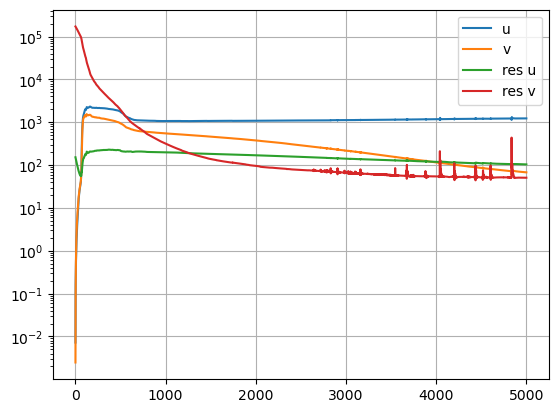

In [47]:
plt.plot(losses2[:, 0], label='u')
plt.plot(losses2[:, 1], label='v')
plt.plot(losses2[:, 2], label='res u')
plt.plot(losses2[:, 3], label='res v')
plt.yscale('log')
plt.grid(); plt.legend(); plt.show()

In [48]:
(u, u_xx, u_yy, u_xy, u_yx, u_t, 
 v, v_xx, v_yy, v_xy, v_yx, v_t) = grads(pinn, pattern.t_star[-1:].astype(np.float32))

In [57]:
def RMSE(arr1, arr2):
    #return np.sqrt(np.mean(((arr1-arr2)/np.max(arr2))**2))
    #return np.sqrt(np.mean(((arr1-arr2)/(arr2+1e-20))**2))
    return np.sqrt(np.mean(((arr1-arr2))**2))
                          
print("u: ", RMSE(u, pattern.c[0,:, : , -1]))
print("v: ", RMSE(v, pattern.c[1,:, : , -1]))
print("u_xx: ", RMSE(u_xx, pattern.c_xx[0,:, : , -1]))
print("v_xx: ", RMSE(v_xx, pattern.c_xx[1,:, : , -1]))
print("u_yy: ", RMSE(u_yy, pattern.c_yy[0,:, : , -1]))
print("v_yy: ", RMSE(v_yy, pattern.c_yy[1,:, : , -1]))
print("u_t: ", RMSE(u_t, pattern.c_t[0,:, : , -1]))
print("v_t: ", RMSE(v_t, pattern.c_t[1,:, : , -1]))

u:  0.6206974
v:  0.1456464
u_xx:  6.5930266
v_xx:  4.1903305
u_yy:  6.65286
v_yy:  4.179528
u_t:  0.008858468
v_t:  0.008213368


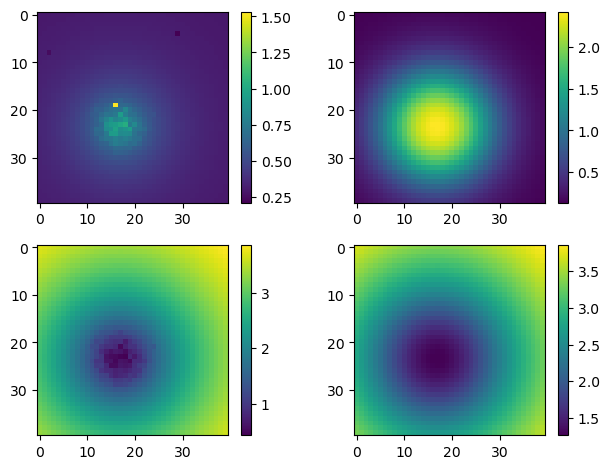

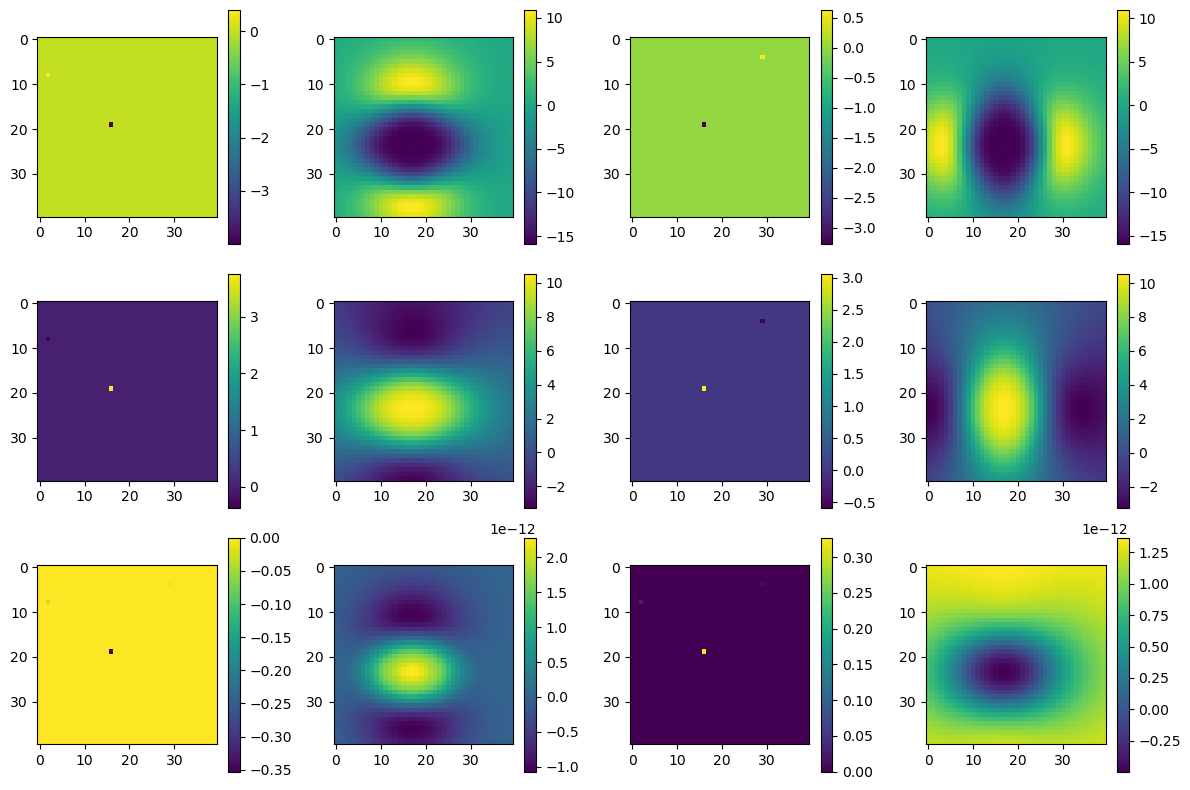

In [58]:
plt.subplot(221)
plt.imshow(u)
plt.colorbar()
plt.subplot(222)
plt.imshow(pattern.c[0,:,:,-1])
plt.colorbar()
plt.subplot(223)
plt.imshow(v)
plt.colorbar()
plt.subplot(224)
plt.imshow(pattern.c[1,:,:,-1])
plt.colorbar()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
plt.subplot(341)
plt.imshow(u_xx)
plt.colorbar()
plt.subplot(342)
plt.imshow(pattern.c_xx[0,:, : , -1])
plt.colorbar()
plt.subplot(343)
plt.imshow(u_yy)
plt.colorbar()
plt.subplot(344)
plt.imshow(pattern.c_yy[0,:, : , -1])
plt.colorbar()
plt.subplot(345)
plt.imshow(v_xx)
plt.colorbar()
plt.subplot(346)
plt.imshow(pattern.c_xx[1,:, : , -1])
plt.colorbar()
plt.subplot(347)
plt.imshow(v_yy)
plt.colorbar()
plt.subplot(3,4,8)
plt.imshow(pattern.c_yy[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.subplot(3,4,9)
plt.imshow(u_t)
plt.colorbar()
plt.subplot(3,4,10)
plt.imshow(pattern.c_t[0,:, : , -1])
plt.colorbar()
plt.subplot(3,4,11)
plt.imshow(v_t)
plt.colorbar()
plt.subplot(3,4,12)
plt.imshow(pattern.c_t[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.show()

In [38]:
class Res_comp_NN(NN_Field3):
    def __init__(self, pinn, x_range, y_range, layers, dim_2d, dtype=tf.float32, **kwargs):
        """A dense Neural Net that is specified by layers argument.

        layers: input, dense layers and outputs dimensions
        """
        self.pre_Ws = [w.numpy() for w in pinn.weights]
        self.pre_as = [a.numpy() for a in pinn.scales]
        self.pre_bs = [b.numpy() for b in pinn.biases]
        super().__init__(x_range, y_range, layers, dim_2d, dtype, **kwargs)
        
    def build(self):
        """Create the state of the layers (weights)"""
        self.pre_weights = []
        self.pre_scales = []
        self.pre_biases = []
        for pre_W, pre_a, pre_b in zip(self.pre_Ws, self.pre_as, self.pre_bs):
            W = tf.Variable(pre_W, trainable=False, dtype=self.dtype)
            a = tf.Variable(pre_a, trainable=False, dtype=self.dtype)
            b = tf.Variable(pre_b, trainable=False, dtype=self.dtype)
            self.pre_weights.append(W)
            self.pre_scales.append(a)
            self.pre_biases.append(b)
            
        self.weights = []
        self.scales = []
        self.biases = []
        for i, (input_n, output_n) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            rnd_init = tf.random_normal_initializer(stddev=1 /(input_n + output_n))
            W = tf.Variable(self.__make_variables__([1, self.dim_2d[0], self.dim_2d[1], input_n, output_n], rnd_init), dtype=self.dtype, name=f"W{i+1}")
            a = tf.Variable(tf.ones([1, self.dim_2d[0], self.dim_2d[1], output_n], dtype=self.dtype), dtype=self.dtype, name=f"a{i+1}")
            b = tf.Variable(tf.zeros([1, self.dim_2d[0], self.dim_2d[1], output_n], dtype=self.dtype), dtype=self.dtype, name=f"b{i+1}")
            self.weights.append(W)
            self.scales.append(a)
            self.biases.append(b)

    @tf.function
    def net(self, H):
        for W, a, b in zip(self.pre_weights, self.pre_scales, self.pre_biases):            
            mul_outputs = [tf.reduce_sum(H*W[:, :, :, :, i], axis=-1) for i in range(W.shape[-1])]            
            mul_outputs =tf.concat([mo[:, :, :, tf.newaxis] for mo in mul_outputs], axis=-1)
            outputs = a * mul_outputs + b
            H = self.act(outputs)
        H_skip = outputs
        H = outputs
        for W, a, b in zip(self.weights, self.scales, self.biases):            
            mul_outputs = [tf.reduce_sum(H*W[:, :, :, :, i], axis=-1) for i in range(W.shape[-1])]            
            mul_outputs =tf.concat([mo[:, :, :, tf.newaxis] for mo in mul_outputs], axis=-1)
            outputs = a * mul_outputs + b
            H = self.act(outputs)
        outputs += H_skip
        return outputs


NameError: name 'NN_Field3' is not defined

In [188]:
p = Res_comp_NN(pinn.copy(), x_range, y_range, 
                layers=[2, 5, 5, 2], 
                dim_2d=(pattern.block_x, pattern.block_x), 
                dtype=tf.float32)

In [189]:
[(w.name, w.shape) for w in p.trainable_variables]

[('b1:0', TensorShape([1, 100, 100, 5])),
 ('b2:0', TensorShape([1, 100, 100, 5])),
 ('b3:0', TensorShape([1, 100, 100, 2])),
 ('a1:0', TensorShape([1, 100, 100, 5])),
 ('a2:0', TensorShape([1, 100, 100, 5])),
 ('a3:0', TensorShape([1, 100, 100, 2])),
 ('W1:0', TensorShape([1, 100, 100, 2, 5])),
 ('W2:0', TensorShape([1, 100, 100, 5, 5])),
 ('W3:0', TensorShape([1, 100, 100, 5, 2]))]

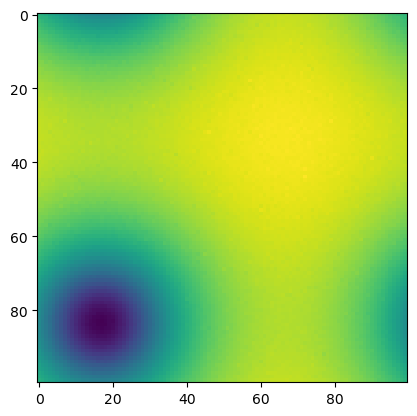

In [190]:
r=p.net(p.make_inputs(pattern.t_star[-1:].astype(np.float32))).numpy()
plt.imshow(r[0,:,:,1])

In [191]:
optimizer2=keras.optimizers.Adam(learning_rate=5e-2).from_config(optimizer.get_config())#keras.optimizers.SGD(learning_rate=1e-4)#
#optimizer2.build(optimizer.variables())


init_per = 2.0
D_u = tf.constant(pattern.params["D_u"], pinn.dtype, name="D_u")#tf.Variable(pattern.params["D_u"]*init_per, pinn.dtype)
D_v = tf.constant(pattern.params["D_v"], pinn.dtype, name="D_v")#tf.Variable(pattern.params["D_v"]*init_per, pinn.dtype)
def clip_by_value_zero_lb(z):
    return tf.clip_by_value(z, 0, 1e10,)

sigma_u = tf.Variable(pattern.params["sigma_u"]*init_per,
                      pinn.dtype,
                      name="sigma_u",
                      constraint=clip_by_value_zero_lb)


sigma_v = tf.Variable(pattern.params["sigma_v"]*init_per,
                      pinn.dtype,
                      name="sigma_v",
                      constraint=clip_by_value_zero_lb)

mu_u = tf.Variable(pattern.params["mu_u"]*init_per,
                   pinn.dtype,
                   name="mu_u",
                   constraint=clip_by_value_zero_lb)

rho_u = tf.Variable(pattern.params["rho_u"]*init_per,
                    pinn.dtype,
                    name="rho_u",
                    constraint=clip_by_value_zero_lb)

rho_v = tf.Variable(pattern.params["rho_v"]*init_per,
                    pinn.dtype,
                    name="rho_v",
                    constraint=clip_by_value_zero_lb)

kappa_u = tf.Variable(pattern.params["kappa_u"]*init_per,
                      pinn.dtype,
                      name="kappa_u",
                      constraint=clip_by_value_zero_lb)


params_tf = (sigma_u, sigma_v, mu_u, rho_u, rho_v, kappa_u,)

# lambda_1 =tf.Variable(1.0, dtype=pinn.dtype)
# lambda_2 =tf.Variable(1.0, dtype=pinn.dtype)
# lambda_3 =tf.Variable(1.0, dtype=pinn.dtype)
# lambda_4 =tf.Variable(1.0, dtype=pinn.dtype)

pinn_copy = p#pinn.copy()

@tf.function
def train_step_inverse(elements):
    with tf.GradientTape(persistent=True) as tape: 
        H = pinn_copy.make_inputs(elements[0])
        tape.watch(H)
        trainables = pinn_copy.trainable_variables
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(H)
            
            outputs = pinn_copy.net(H)            
            u = tf.squeeze(outputs[:, :, :, 0])
            v = tf.squeeze(outputs[:, :, :, 1])
            
            grad_u = tape2.gradient(u, H)
            u_x = grad_u[:, :, :, 0]
            u_y = grad_u[:, :, :, 1]
            u_t = grad_u[:, :, :, 2]
            
            grad_v = tape2.gradient(v, H)
            v_x = grad_v[:, :, :, 0]
            v_y = grad_v[:, :, :, 1]
            v_t = grad_v[:, :, :, 2]
                    
        grad_u_x = tape.gradient(u_x, H)
        u_xx = grad_u_x[:, :, :, 0]
        #u_yx = grad_u_x[:, :, :, 1]
        #u_tx = grad_u_x[:, :, :, 2]
        grad_u_y = tape.gradient(u_y, H)
        #u_xy = grad_u_y[:, :, :, 0]
        u_yy = grad_u_y[:, :, :, 1]
        #u_ty = grad_u_y[:, :, :, 2]
        grad_v_x = tape.gradient(v_x, H)
        v_xx = grad_v_x[:, :, :, 0]
        #v_yx = grad_v_x[:, :, :, 1]
        #v_tx = grad_v_x[:, :, :, 2]
        grad_v_y = tape.gradient(v_y, H)
        #v_xy = grad_v_y[:, :, :, 0]
        v_yy = grad_v_y[:, :, :, 1]
        #v_ty = grad_v_y[:, :, :, 2]
                             
        f = u * u * v / (1.0 + kappa_u * u * u)
        f_u = D_u * (u_xx + u_yy) + rho_u * f - mu_u * u + sigma_u - u_t
        f_v = D_v * (v_xx + v_yy) - rho_v * f + sigma_v - v_t
        l2_res_u = tf.reduce_sum(f_u**2)
        l2_res_v = tf.reduce_sum(f_v**2)
        
        u_diff = u - elements[1][:, 0, :, :]
        v_diff = v - elements[1][:, 1, :, :]
        l2_u_obs = tf.reduce_sum(u_diff**2)
        l2_v_obs = tf.reduce_sum(v_diff**2)

        #u_xyyx_diff = u_xy - u_yx
        #v_xyyx_diff = v_xy - v_yx
        #l2_res_u_xyyx = tf.reduce_sum(u_xyyx_diff**2)
        #l2_res_v_xyyx = tf.reduce_sum(v_xyyx_diff**2)

                
        #l2 = lambda_1*l2_u_obs + lambda_2*l2_v_obs + lambda_3*l2_res_u + lambda_4*l2_res_v# + l2_res_u_xyyx + l2_res_v_xyyx
        l2 = l2_u_obs + l2_v_obs + l2_res_u + l2_res_v# + l2_res_u_xyyx + l2_res_v_xyyx
       
    grads = tape.gradient(l2, trainables + params_tf)
    optimizer2.apply_gradients(zip(grads, trainables + params_tf))
    ##############################################
#     g1 = tf.reduce_sum([tf.reduce_sum(item**2) for item in tf.gradients(l2_u_obs, trainables)])
#     g2 = tf.reduce_sum([tf.reduce_sum(item**2) for item in tf.gradients(l2_v_obs, trainables)])
#     g3 = tf.reduce_sum([tf.reduce_sum(item**2) for item in tf.gradients(l2_res_u, trainables)])
#     g4 = tf.reduce_sum([tf.reduce_sum(item**2) for item in tf.gradients(l2_res_v, trainables)])
#     penalty_power = 2
#     W1 = g1**penalty_power/tf.sqrt(l2_u_obs)
#     W2 = g2**penalty_power/tf.sqrt(l2_v_obs)
#     W3 = g3**penalty_power/tf.sqrt(l2_res_u)
#     W4 = g4**penalty_power/tf.sqrt(l2_res_v)

#     w_total = W1 + W2 + W3 + W4
#     alpha=.2
#     lambda_1.assign(alpha*lambda_1 + (1.0-alpha)*4.0*W1/w_total)
#     lambda_2.assign(alpha*lambda_2 + (1.0-alpha)*4.0*W2/w_total)
#     lambda_3.assign(alpha*lambda_3 + (1.0-alpha)*4.0*W3/w_total)
#     lambda_4.assign(alpha*lambda_4 + (1.0-alpha)*4.0*W4/w_total)
    
    ###############################################
    return (l2_u_obs, l2_v_obs, l2_res_u, l2_res_v)#, lambda_1, lambda_2, lambda_3, lambda_4, w_total)


In [201]:
??p.act

In [195]:
batch_size = 1
def print_callback2(printer, losses, epoch):    
    printer(f"at epoch {epoch:d}\n"
            f" total loss: {np.sum(losses[:4])}"
            f" u: {losses[0]}, v: {losses[1]},\n"
            f" Res u: {losses[2]}, Res v: {losses[3]} \n"            
            #f" lambda 1: {losses[4]}, lambda 2: {losses[5]} \n"
            #f" lambda 3: {losses[6]}, lambda 4: {losses[7]} \n"
            #f"W {losses[8]}"
           )
    printer(#f"D_u: {D_u.numpy()}, D_v: {D_v.numpy()} \n"
             f"rho_u: {rho_u.numpy()}, rho_v: {rho_v.numpy()} \n"
             f"sigma_u: {sigma_u.numpy()}, sigma_v: {sigma_v.numpy()} \n"
             f"kappa_u: {kappa_u.numpy()}, mu_u: {mu_u.numpy()} \n")            
        
losses2 = tu.train(epochs=2000+1,
                  batch_size=batch_size,
                  dataset = ds ,
                  train_step = train_step_inverse,
                  train_step_returns_num = 4,
                  print_interval=100,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback2,
                  epoch_callback=None)


Start of epoch 0
at epoch 0
 total loss: 2065.098680496216 u: 1745.9428100585938, v: 241.60252380371094,
 Res u: 42.30122375488281, Res v: 35.25212287902832 

rho_u: 0.4707496464252472, rho_v: 5.798692226409912 
sigma_u: 0.0, sigma_v: 2.0077157020568848 
kappa_u: 0.18531034886837006, mu_u: 0.49892348051071167 

Time taken: 0.18s

Start of epoch 100
at epoch 100
 total loss: 1943.271448135376 u: 1653.6845092773438, v: 252.3879852294922,
 Res u: 8.988475799560547, Res v: 28.210477828979492 

rho_u: 0.18361330032348633, rho_v: 5.803556442260742 
sigma_u: 0.0, sigma_v: 1.9164904356002808 
kappa_u: 0.18633723258972168, mu_u: 0.18331563472747803 

Time taken: 10.00s

Start of epoch 200
at epoch 200
 total loss: 1860.8815672695637 u: 1563.5122680664062, v: 271.604248046875,
 Res u: 0.32160308957099915, Res v: 25.443448066711426 

rho_u: 0.029245935380458832, rho_v: 5.809158802032471 
sigma_u: 0.0, sigma_v: 1.8076024055480957 
kappa_u: 0.1875413954257965, mu_u: 0.026027463376522064 

Time tak

In [203]:
losses3 = tu.train(epochs=10000+1,
                  batch_size=batch_size,
                  dataset = ds ,
                  train_step = train_step_inverse,
                  train_step_returns_num = 4,
                  print_interval=200,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback2,
                  epoch_callback=None)


Start of epoch 0
at epoch 0
 total loss: 1725.2946963624563 u: 1399.2131958007812, v: 290.60247802734375,
 Res u: 0.0035453157033771276, Res v: 35.47547721862793 

rho_u: 0.001389582408592105, rho_v: 5.738277912139893 
sigma_u: 0.0, sigma_v: 1.079080581665039 
kappa_u: 0.24601975083351135, mu_u: 0.0 

Time taken: 0.19s

Start of epoch 200
at epoch 200
 total loss: 1723.0993577903137 u: 1397.6687622070312, v: 289.2675018310547,
 Res u: 0.0035440390929579735, Res v: 36.159549713134766 

rho_u: 0.0013870703987777233, rho_v: 5.706783771514893 
sigma_u: 0.0, sigma_v: 1.0752032995224 
kappa_u: 0.2617134749889374, mu_u: 0.0 

Time taken: 20.35s

Start of epoch 400
at epoch 400
 total loss: 1720.3570427721133 u: 1395.7017211914062, v: 287.6202392578125,
 Res u: 0.0035424059024080634, Res v: 37.03153991699219 

rho_u: 0.0013836537254974246, rho_v: 5.667195796966553 
sigma_u: 0.0, sigma_v: 1.0702166557312012 
kappa_u: 0.28101906180381775, mu_u: 0.0 

Time taken: 20.41s

Start of epoch 600
at ep


Start of epoch 5000
at epoch 5000
 total loss: 0.2114119528559968 u: 0.002045416389591992, v: 0.17906095832586288,
 Res u: 0.0017164319287985563, Res v: 0.028589146211743355 

rho_u: 0.0016857837326824665, rho_v: 0.0037308803293854 
sigma_u: 0.0, sigma_v: 0.00560902850702405 
kappa_u: 1.3321046829223633, mu_u: 0.0 

Time taken: 20.21s

Start of epoch 5200
at epoch 5200
 total loss: 0.2123501586029306 u: 0.0021713764872401953, v: 0.17871665954589844,
 Res u: 0.0018613924039527774, Res v: 0.029600730165839195 

rho_u: 0.0014151064679026604, rho_v: 0.0036717746406793594 
sigma_u: 0.0, sigma_v: 0.006055119447410107 
kappa_u: 1.3321046829223633, mu_u: 0.0 

Time taken: 20.35s

Start of epoch 5400
at epoch 5400
 total loss: 0.21406660531647503 u: 0.002457972848787904, v: 0.17842428386211395,
 Res u: 0.0017054174095392227, Res v: 0.031478931196033955 

rho_u: 0.0016737396363168955, rho_v: 0.0036333685275167227 
sigma_u: 0.0, sigma_v: 0.006225055083632469 
kappa_u: 1.3321046829223633, mu_u: 0


Start of epoch 10000
at epoch 10000
 total loss: 0.21274061052827165 u: 0.005113770253956318, v: 0.17701835930347443,
 Res u: 0.0022274108487181365, Res v: 0.028381070122122765 

rho_u: 0.0012251187581568956, rho_v: 0.0034784586168825626 
sigma_u: 0.0, sigma_v: 0.006016682367771864 
kappa_u: 1.3393391370773315, mu_u: 0.0 

Time taken: 20.39s


In [ ]:
'rho_u': 0.4,  'rho_v': 3.0,
'sigma_u': 0.1, 'sigma_v': 1.0,
'kappa_u': 0.0, 'mu_u': 1.0,

In [202]:
pattern.params

{'D_u': 0.02,
 'D_v': 1.0,
 'kappa_u': 0.0,
 'rho_u': 0.4,
 'mu_u': 1.0,
 'sigma_u': 0.1,
 'rho_v': 3.0,
 'sigma_v': 1.0}

In [204]:
def Euclidian_L(vec1, vec2):
    def L(v):
        return np.sqrt(np.sum(v**2))
    v2 = vec2.copy()
    v2[v2==0] = 1
    return L((vec1-vec2)/v2)

u_vec_ac = np.array([pattern.params["rho_u"], pattern.params["mu_u"],
                     pattern.params["sigma_u"], pattern.params["kappa_u"]])

u_vec    = np.array([rho_u.numpy(), mu_u.numpy(), sigma_u.numpy(), kappa_u.numpy()])

v_vec_ac = np.array([pattern.params["rho_v"], 
                     pattern.params["sigma_v"], pattern.params["kappa_u"]])

v_vec    = np.array([rho_v.numpy(), sigma_v.numpy(), kappa_u.numpy()])

print(f"U params. estimates: {Euclidian_L(u_vec, u_vec_ac)}")
print(f"V params. estimates: {Euclidian_L(v_vec, v_vec_ac)}")

U params. estimates: 2.188084347332408
V params. estimates: 1.9440973565732833


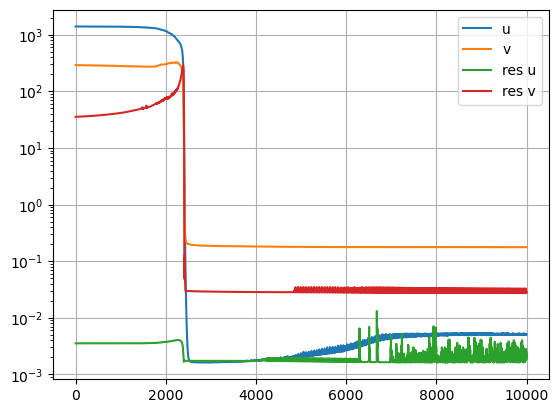

In [205]:
plt.plot(losses3[0:, 0], label='u')
plt.plot(losses3[0:, 1], label='v')
plt.plot(losses3[:, 2], label='res u')
plt.plot(losses3[:, 3], label='res v')
plt.yscale('log')
plt.grid(); plt.legend(); plt.show()

In [206]:
(u, u_xx, u_yy, u_xy, u_yx, u_t, 
 v, v_xx, v_yy, v_xy, v_yx, v_t) = grads(pinn_copy, pattern.t_star[-1:].astype(np.float32))

In [207]:
def RMSE(arr1, arr2):
    #return np.sqrt(np.mean(((arr1-arr2)/np.max(arr2))**2))
    #return np.sqrt(np.mean(((arr1-arr2)/(arr2+1e-20))**2))
    return np.sqrt(np.mean(((arr1-arr2))**2))
                          
print("u: ", RMSE(u, pattern.c[0,:, : , -1]))
print("v: ", RMSE(v, pattern.c[1,:, : , -1]))
print("u_xx: ", RMSE(u_xx, pattern.c_xx[0,:, : , -1]))
print("v_xx: ", RMSE(v_xx, pattern.c_xx[1,:, : , -1]))
print("u_yy: ", RMSE(u_yy, pattern.c_yy[0,:, : , -1]))
print("v_yy: ", RMSE(v_yy, pattern.c_yy[1,:, : , -1]))
print("u_t: ", RMSE(u_t, pattern.c_t[0,:, : , -1]))
print("v_t: ", RMSE(v_t, pattern.c_t[1,:, : , -1]))

u:  0.0002548442
v:  0.0024549223
u_xx:  2.7187912
v_xx:  1.8820696
u_yy:  2.7187912
v_yy:  1.8820698
u_t:  0.0005494114
v_t:  0.00542152


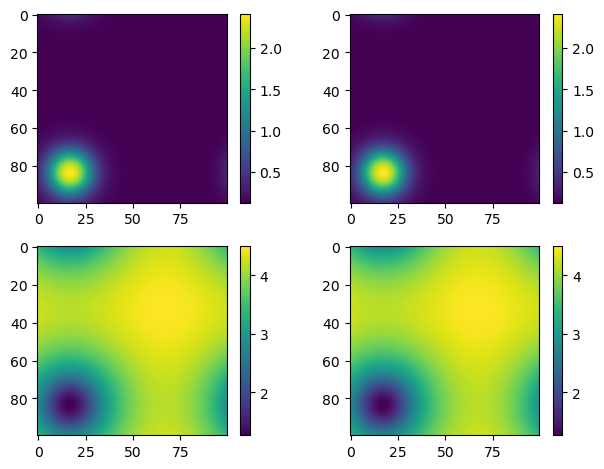

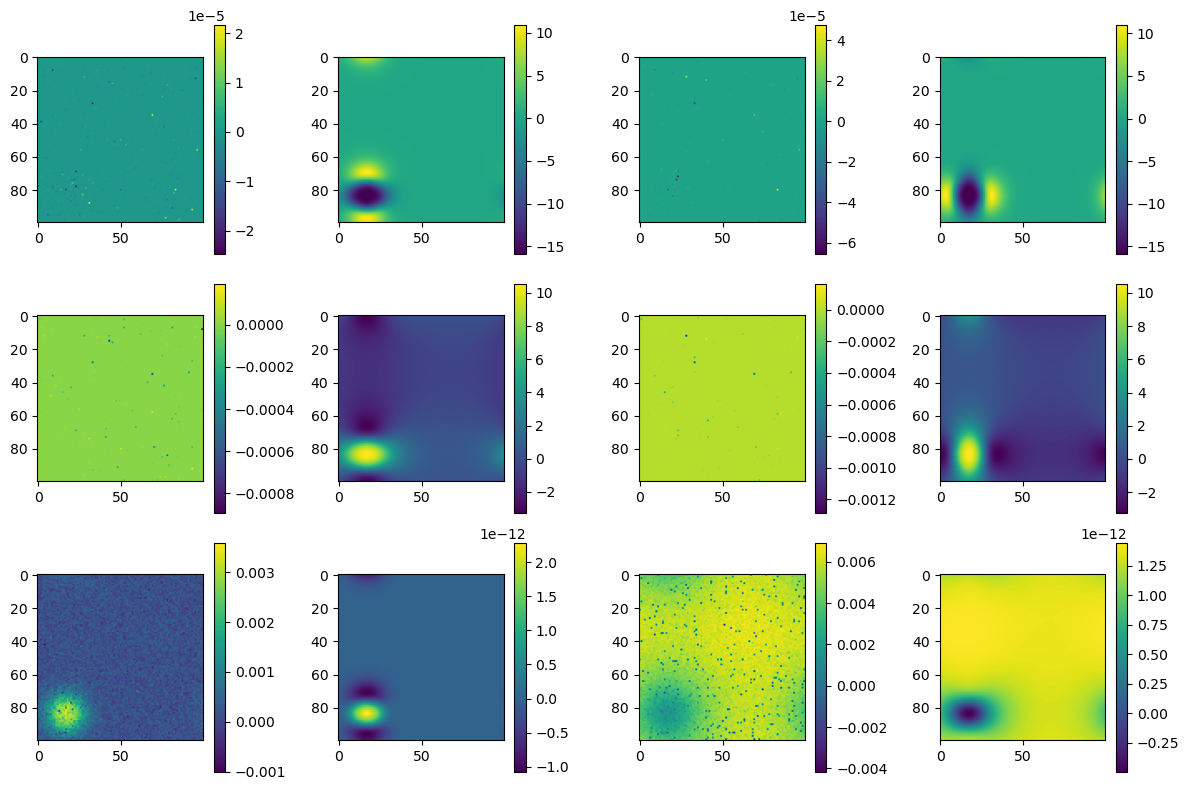

In [208]:
plt.subplot(221)
plt.imshow(u)
plt.colorbar()
plt.subplot(222)
plt.imshow(pattern.c[0,:,:,-1])
plt.colorbar()
plt.subplot(223)
plt.imshow(v)
plt.colorbar()
plt.subplot(224)
plt.imshow(pattern.c[1,:,:,-1])
plt.colorbar()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
plt.subplot(341)
plt.imshow(u_xx)
plt.colorbar()
plt.subplot(342)
plt.imshow(pattern.c_xx[0,:, : , -1])
plt.colorbar()
plt.subplot(343)
plt.imshow(u_yy)
plt.colorbar()
plt.subplot(344)
plt.imshow(pattern.c_yy[0,:, : , -1])
plt.colorbar()
plt.subplot(345)
plt.imshow(v_xx)
plt.colorbar()
plt.subplot(346)
plt.imshow(pattern.c_xx[1,:, : , -1])
plt.colorbar()
plt.subplot(347)
plt.imshow(v_yy)
plt.colorbar()
plt.subplot(3,4,8)
plt.imshow(pattern.c_yy[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.subplot(3,4,9)
plt.imshow(u_t)
plt.colorbar()
plt.subplot(3,4,10)
plt.imshow(pattern.c_t[0,:, : , -1])
plt.colorbar()
plt.subplot(3,4,11)
plt.imshow(v_t)
plt.colorbar()
plt.subplot(3,4,12)
plt.imshow(pattern.c_t[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.show()